In [25]:
import pandas as pd
from sklearn import tree

In [26]:
df = pd.read_csv("features_df.csv")

df = df.dropna(axis='columns', how='all')

df = df.dropna()
df.head()

,actual,estimate,period,symbol,year,quarter,beat,f1_pup,f2_vup,f3_bothup,f4_average_price
0,1.00,1.1300,2019-12-31,YUM,2019,4,0,0.390625,0.437500,0.187500,103.581563
1,0.80,0.9400,2019-09-30,YUM,2019,3,0,0.468750,0.468750,0.171875,114.279531
2,0.93,0.8700,2019-06-30,YUM,2019,2,1,0.619048,0.460317,0.253968,103.853810
3,0.82,0.8100,2019-03-31,YUM,2019,1,1,0.573770,0.557377,0.327869,94.701148
4,0.40,0.9485,2018-12-31,YUM,2018,4,0,0.523810,0.444444,0.285714,89.395556


In [27]:
len(df)

3600

In [28]:
newdf = df[["symbol", "year", "quarter", "f1_pup", "f2_vup", "f3_bothup", "f4_average_price", "estimate", "beat"]]

In [29]:
df_train = newdf.loc[df["year"] <= 2016]
df_test = newdf.loc[df["year"] >= 2017]

In [30]:
X_train = df_train[['f1_pup', 'f2_vup', 'f3_bothup', 'f4_average_price', 'estimate']]
X_test = df_test[['f1_pup', 'f2_vup', 'f3_bothup', 'f4_average_price', 'estimate']]
y_train = df_train['beat']
y_test = df_test['beat']

In [31]:
len(X_train)

3000

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)

In [45]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
importances = rf.feature_importances_
feature_names = X_train.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.2570688241687903, 'estimate'),
 (0.25603017125111277, 'f4_average_price'),
 (0.167708804810452, 'f1_pup'),
 (0.16003185279592136, 'f2_vup'),
 (0.15916034697372358, 'f3_bothup')]

In [47]:
rf.score(X_train_scaled, y_train)

1.0

In [48]:
rf.score(X_test_scaled, y_test)

0.8433333333333334

In [49]:
predictions = rf.predict(X_test_scaled)

In [50]:
dd = pd.DataFrame({"Prediction": predictions, "Actual":y_test})
dd.head()

,Prediction,Actual
0,1,0
1,1,0
2,1,1
3,1,1
4,1,0


In [51]:
df['Prediction'] = dd['Prediction']
df.head()

,actual,estimate,period,symbol,year,quarter,beat,f1_pup,f2_vup,f3_bothup,f4_average_price,Prediction
0,1.00,1.1300,2019-12-31,YUM,2019,4,0,0.390625,0.437500,0.187500,103.581563,1.0
1,0.80,0.9400,2019-09-30,YUM,2019,3,0,0.468750,0.468750,0.171875,114.279531,1.0
2,0.93,0.8700,2019-06-30,YUM,2019,2,1,0.619048,0.460317,0.253968,103.853810,1.0
3,0.82,0.8100,2019-03-31,YUM,2019,1,1,0.573770,0.557377,0.327869,94.701148,1.0
4,0.40,0.9485,2018-12-31,YUM,2018,4,0,0.523810,0.444444,0.285714,89.395556,1.0


In [52]:
# To Confirm the accuracy of testing data
s = dd["Prediction"].count()
wrong = 0
for i in range(0,s):
    a=dd["Prediction"].iloc[i]
    b=dd["Actual"].iloc[i]
    if a != b:
        wrong = wrong + 1
        
(s - wrong) / s

0.8433333333333334

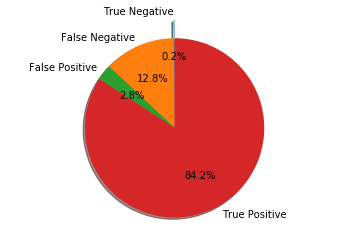

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf = confusion_matrix(dd['Actual'], dd['Prediction'])

tn = conf[0][0]
fp = conf[0][1]
fn = conf[1][0]
tp = conf[1][1]

labels = 'True Negative', 'False Negative', 'False Positive', 'True Positive'
sizes = [tn,fp,fn,tp]
explode = (0.2, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [54]:
target_names = ["Not Beat", "Beat"]
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

    Not Beat       0.06      0.01      0.02        78
        Beat       0.87      0.97      0.91       522

    accuracy                           0.84       600
   macro avg       0.46      0.49      0.47       600
weighted avg       0.76      0.84      0.80       600



In [55]:
df_check = dd.loc[dd["Prediction"] == 0]
df_check.head()

,Prediction,Actual
80,0,0
153,0,1
506,0,1
1158,0,1
1588,0,1


# Hyperparameter Tuning

In [65]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'criterion' : ['gini', 'entropy']}

grid = GridSearchCV(rf, param_grid, verbose = 3)

In [66]:
grid.fit(X_train_scaled, y_train)

C:\Users\ashka\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] criterion=gini, n_estimators=50 .................................
[CV] ..... criterion=gini, n_estimators=50, score=0.784, total=   0.2s
[CV] criterion=gini, n_estimators=50 .................................
[CV] ..... criterion=gini, n_estimators=50, score=0.791, total=   0.2s
[CV] criterion=gini, n_estimators=50 .................................
[CV] ..... criterion=gini, n_estimators=50, score=0.766, total=   0.2s
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .... criterion=gini, n_estimators=100, score=0.789, total=   0.3s
[CV] criterion=gini, n_estimators=100 ................................
[CV] .... criterion=gini, n_estimators=100, score=0.789, total=   0.3s
[CV] criterion=gini, n_estimators=100 ................................
[CV] .... criterion=gini, n_estimators=100, score=0.763, total=   0.4s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.791, total=   0.7s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.796, total=   0.7s
[CV] criterion=gini, n_estimators=200 ................................
[CV] .... criterion=gini, n_estimators=200, score=0.768, total=   0.6s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .. criterion=entropy, n_estimators=50, score=0.787, total=   0.2s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    8.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [67]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'n_estimators': 200}
0.785


In [68]:
predictions = grid.predict(X_test_scaled)

In [69]:
target_names = ["Not Beat", "Beat"]
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

    Not Beat       0.09      0.01      0.02        78
        Beat       0.87      0.98      0.92       522

    accuracy                           0.85       600
   macro avg       0.48      0.50      0.47       600
weighted avg       0.77      0.85      0.80       600



In [70]:
print(f"Training Data Score: {grid.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {grid.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.855


In [71]:
gg = pd.DataFrame({"Prediction": predictions, "Actual":y_test})
gg.head()

,Prediction,Actual
0,1,0
1,1,0
2,1,1
3,1,1
4,1,0


In [72]:
s = gg["Prediction"].count()
wrong = 0
for i in range(0,s):
    a=gg["Prediction"].iloc[i]
    b=gg["Actual"].iloc[i]
    if a != b:
        wrong = wrong + 1
        
(s - wrong) / s

0.855

In [73]:
df_check = dd.loc[gg["Prediction"] == 0]
df_check.head()

,Prediction,Actual
728,1,1
874,1,0
1588,0,1
1660,1,1
2305,1,1
